In [ ]:
import os
import sys
import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

sys.path.append('/home/nadir/tmr-code')

from src.config import read_config
from src.load import load_model_from_cfg
from hydra.utils import instantiate
import pytorch_lightning as pl

In [3]:
print("[mean]", torch.mean(torch.load("/home/nadir/tmr-code/stats/humanml3d/guoh3dfeats/mean.pt")))
print("[std]", torch.std(torch.load("/home/nadir/tmr-code/stats/humanml3d/guoh3dfeats/mean.pt")))

[mean] tensor(0.1870)
[std] tensor(0.4149)


In [4]:
from src.data.motion import AMASSMotionLoader, Normalizer
from dataset_embeddings_analysis import SegmentsBabelDataset, BabelDatasetSplit

In [5]:
normalizer = Normalizer(
    base_dir="/home/nadir/tmr-code/stats/humanml3d/guoh3dfeats"
)

loader = AMASSMotionLoader(
    base_dir="/home/nadir/disk/codes/human-ml3d-code/amass_data",
    fps=20,
    normalizer=normalizer
)

dataset = SegmentsBabelDataset(
    annotations_dir="/home/nadir/babel-dataset/data/babel",
    splits=BabelDatasetSplit.TRAIN,
)

dataset[0]

{'sid': '5788',
 'amass_file_relative_path': 'BioMotionLab_NTroje/rub055/0020_lifting_heavy2_poses.npz',
 'annotations': [{'act_cat': ['walk'],
   'annotation': 'walk',
   'start_t': 0,
   'end_t': 1.523},
  {'act_cat': ['transition'],
   'annotation': 'transition',
   'start_t': 1.523,
   'end_t': 1.752},
  {'act_cat': ['take/pick something up'],
   'annotation': 'take',
   'start_t': 1.752,
   'end_t': 2.44},
  {'act_cat': ['place something'],
   'annotation': 'place',
   'start_t': 2.44,
   'end_t': 4.023},
  {'act_cat': ['transition'],
   'annotation': 'transition',
   'start_t': 4.023,
   'end_t': 4.19},
  {'act_cat': ['turn'], 'annotation': 'turn', 'start_t': 4.19, 'end_t': 5.127},
  {'act_cat': ['walk'],
   'annotation': 'walk',
   'start_t': 5.127,
   'end_t': 6.767}]}

In [6]:
samples = []

for sample in dataset:
    for annotation in sample["annotations"]:
        actions = annotation["act_cat"]
        for action in actions:
            samples.append({
                'action': action,
                'annotation': annotation['annotation'],
                'start_t': annotation['start_t'],
                'end_t': annotation['end_t'],
                'amass_file_relative_path': sample['amass_file_relative_path']
            })

In [7]:
RUN_DIR = "/home/nadir/tmr-code/outputs/tmr_humanml3d_guoh3dfeats"
DEVICE = "cuda:1"
CKPT_NAME = "last"
DATA_DIR = "/home/nadir/windowed-babel-for-classification-for-validation"
MAX_SEQUENCES_TO_ANALYZE = 2048
IOU_DETECTION_THRESHOLD = 0.5

In [ ]:
cfg = read_config(RUN_DIR)
pl.seed_everything(cfg.seed)

model = load_model_from_cfg(cfg, CKPT_NAME, eval_mode=True, device=DEVICE).eval()

model.motion_encoder

Global seed set to 1234


ACTORStyleEncoder(
  (projection): Linear(in_features=263, out_features=256, bias=True)
  (sequence_pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (seqTransEncoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [9]:
def batcherize(motion):
    motion['x'] = motion['x'].unsqueeze(0)
    motion['mask'] = torch.ones(motion['length'], device=DEVICE, dtype=torch.bool).unsqueeze(0)
    motion['length'] = [motion['length']]
    
    motion['x'] = motion['x'].to(DEVICE)
    
    return motion

In [ ]:
actions = list(set([sample["action"] for sample in samples]))

In [16]:
skipped_indices = []

for index, sample in tqdm.tqdm(iterable=enumerate(samples), total=len(samples), desc="[processing]:"):
    try:
        motion = batcherize(loader(sample['amass_file_relative_path'].split(".")[0], sample['start_t'], sample['end_t']))
        action = sample['action']
        
        embedding = model.motion_encoder(motion)
        
        torch.save(embedding, os.path.join("tmp", action, f"{index}.pt"))
    except Exception as exception:
        skipped_indices.append(index)
        print(f"[skipping]: failed for sample({index}) due to {exception}")

[processing]:: 100%|██████████| 51823/51823 [04:26<00:00, 194.24it/s]


In [19]:
torch.load("/home/nadir/tmr-code/tmp/action with ball/393.pt").squeeze(0).shape

torch.Size([2, 256])

In [ ]:
action_stats = {}

for action in actions:
    folder = os.path.join("tmp", action)
    files = [f for f in os.listdir(folder) if f.endswith(".pt")]

    count = 0
    mean = 0
    M2 = 0

    for file in files:
        mu, logvar = torch.load(os.path.join(folder, file)).squeeze(0)
        embedding = mu
        embedding = embedding.view(-1)

        count += 1
        delta = embedding - mean
        mean += delta / count
        delta2 = embedding - mean
        M2 += delta * delta2

    variance = M2 / (count - 1) if count > 1 else torch.zeros_like(mean)

    action_stats[action] = {
        "mean": mean,
        "variance": variance,
        "count": count
    }

print("Stats per action computed.")

Stats per action computed.


[count]: 10597
[]: tensor(5.1254, device='cuda:1', grad_fn=<MeanBackward0>)
[]: tensor(3.6796, device='cuda:1', grad_fn=<MeanBackward0>)
[]: tensor(3.6182, device='cuda:1', grad_fn=<MeanBackward0>)


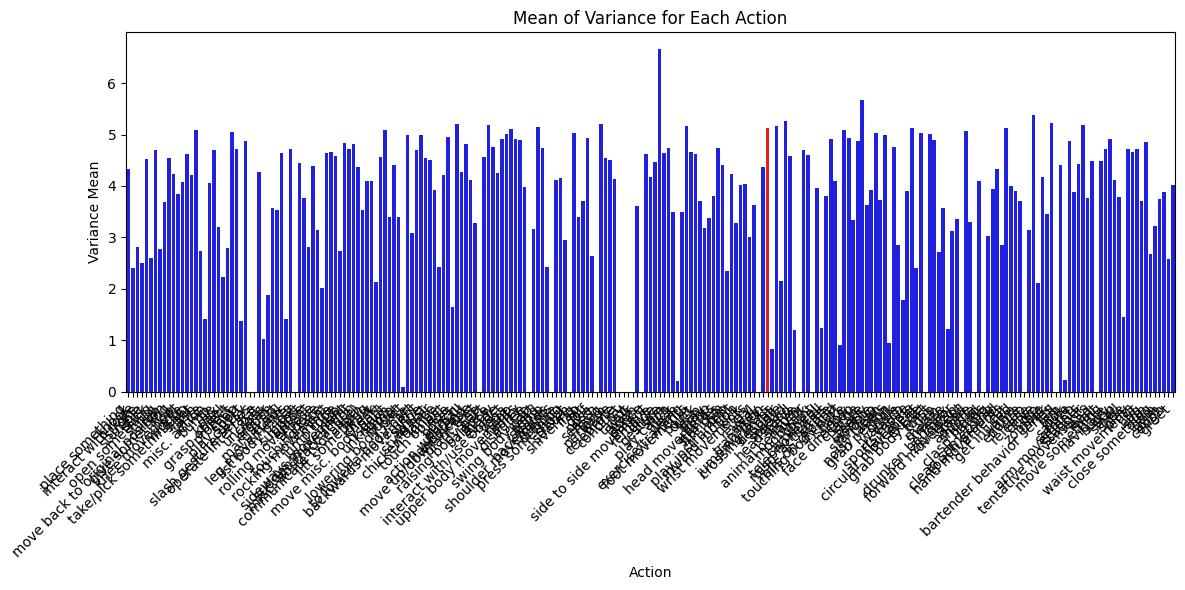

In [42]:
print("[count]:", action_stats['transition']['count'])

print("[]:", action_stats["transition"]['variance'].mean())

print("[]:", action_stats["run"]['variance'].mean())
print("[]:", action_stats["walk"]['variance'].mean())

action_names = list(action_stats.keys())
variance_means = [action_stats[action]['variance'].mean().item() for action in action_names]

df = pd.DataFrame({'Action': action_names, 'Variance Mean': variance_means})

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Action', y='Variance Mean', data=df, palette=['r' if action == 'transition' else 'b' for action in df['Action']])
plt.xticks(rotation=45, ha='right')
plt.title('Mean of Variance for Each Action')
plt.tight_layout()
plt.show()

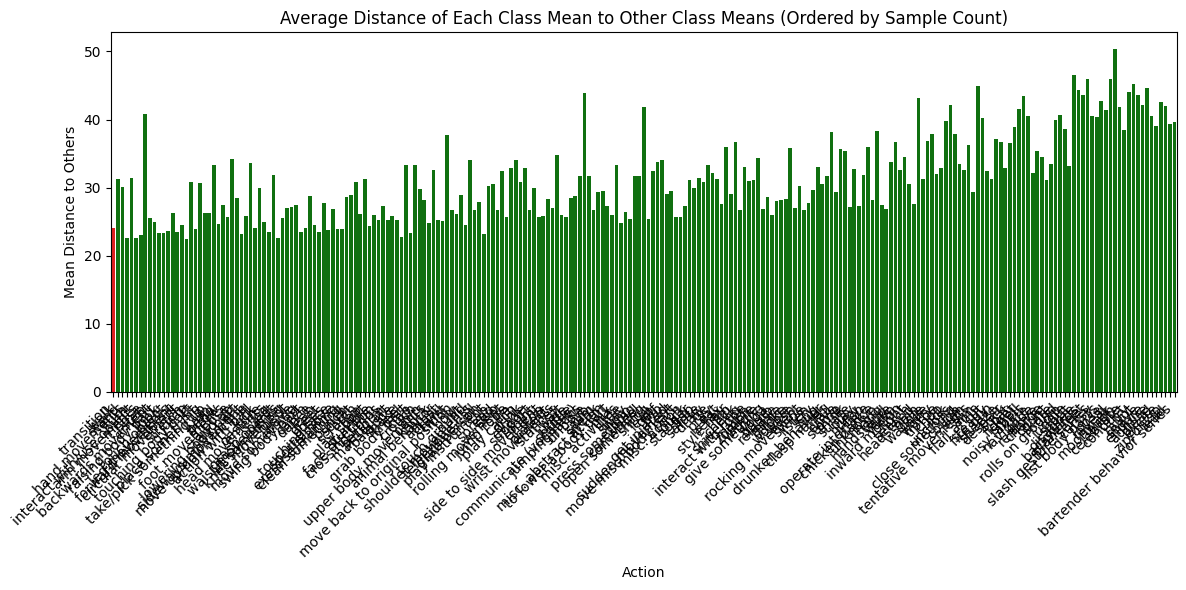

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

mean_distances = {}

for action_a in action_stats:
    mean_a = action_stats[action_a]["mean"]
    distances = []

    for action_b in action_stats:
        if action_a == action_b:
            continue
        mean_b = action_stats[action_b]["mean"]
        dist = torch.norm(mean_a - mean_b, p=2).item()
        distances.append(dist)

    mean_distances[action_a] = sum(distances) / len(distances)

df_dist = pd.DataFrame({
    'Action': list(mean_distances.keys()),
    'Mean Distance to Others': [mean_distances[action] for action in mean_distances],
    'Count': [action_stats[action]['count'] for action in mean_distances]
})

df_dist = df_dist.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Action',
    y='Mean Distance to Others',
    data=df_dist,
    order=df_dist['Action'],
    palette=['r' if action == 'transition' else 'g' for action in df_dist['Action']]
)
plt.xticks(rotation=45, ha='right')
plt.title('Average Distance of Each Class Mean to Other Class Means (Ordered by Sample Count)')
plt.tight_layout()
plt.show()

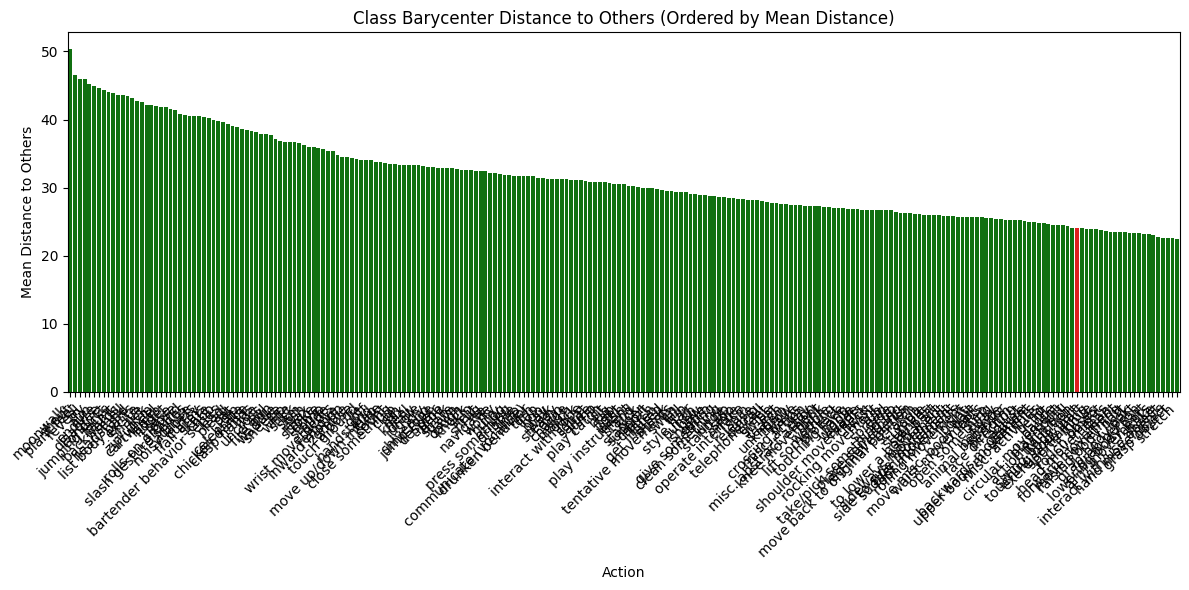

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

mean_distances = {}

for action_a in action_stats:
    mean_a = action_stats[action_a]["mean"]
    distances = []

    for action_b in action_stats:
        if action_a == action_b:
            continue
        mean_b = action_stats[action_b]["mean"]
        dist = torch.norm(mean_a - mean_b, p=2).item()
        distances.append(dist)

    mean_distances[action_a] = sum(distances) / len(distances)

df_dist = pd.DataFrame({
    'Action': list(mean_distances.keys()),
    'Mean Distance to Others': [mean_distances[action] for action in mean_distances],
    'Count': [action_stats[action]['count'] for action in mean_distances]
})

df_dist = df_dist.sort_values(by='Mean Distance to Others', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Action',
    y='Mean Distance to Others',
    data=df_dist,
    order=df_dist['Action'],
    palette=['r' if action == 'transition' else 'g' for action in df_dist['Action']]
)
plt.xticks(rotation=45, ha='right')
plt.title('Class Barycenter Distance to Others (Ordered by Mean Distance)')
plt.tight_layout()
plt.show()

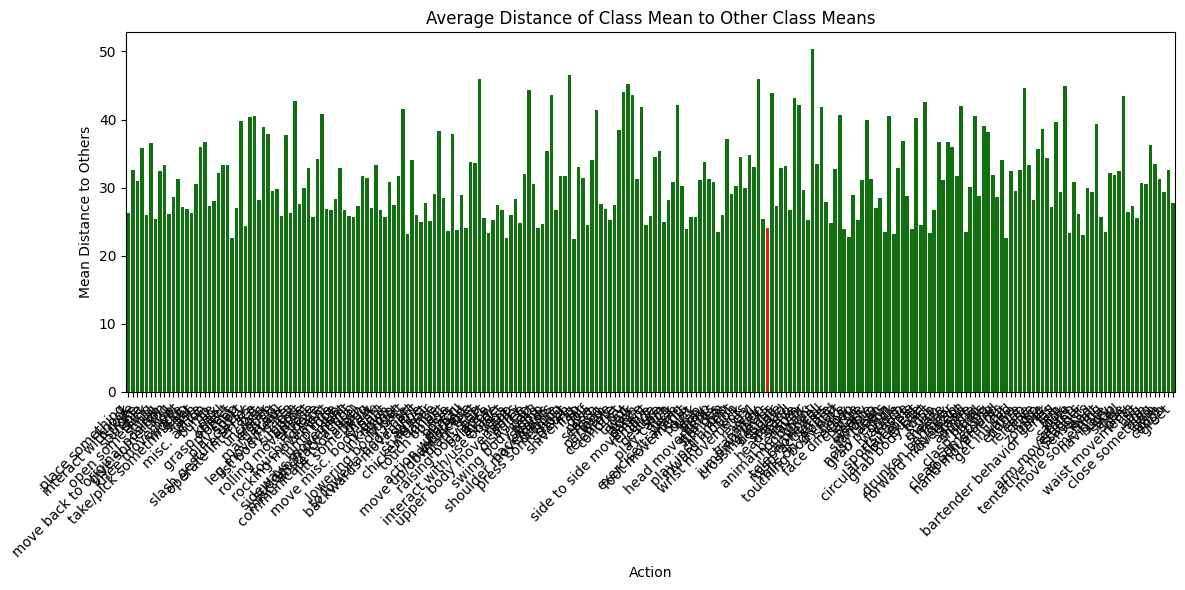

In [44]:
df_dist = pd.DataFrame({
    'Action': list(mean_distances.keys()),
    'Mean Distance to Others': list(mean_distances.values())
})

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Action',
    y='Mean Distance to Others',
    data=df_dist,
    palette=['r' if action == 'transition' else 'g' for action in df_dist['Action']]
)
plt.xticks(rotation=45, ha='right')
plt.title('Average Distance of Class Mean to Other Class Means')
plt.tight_layout()
plt.show()

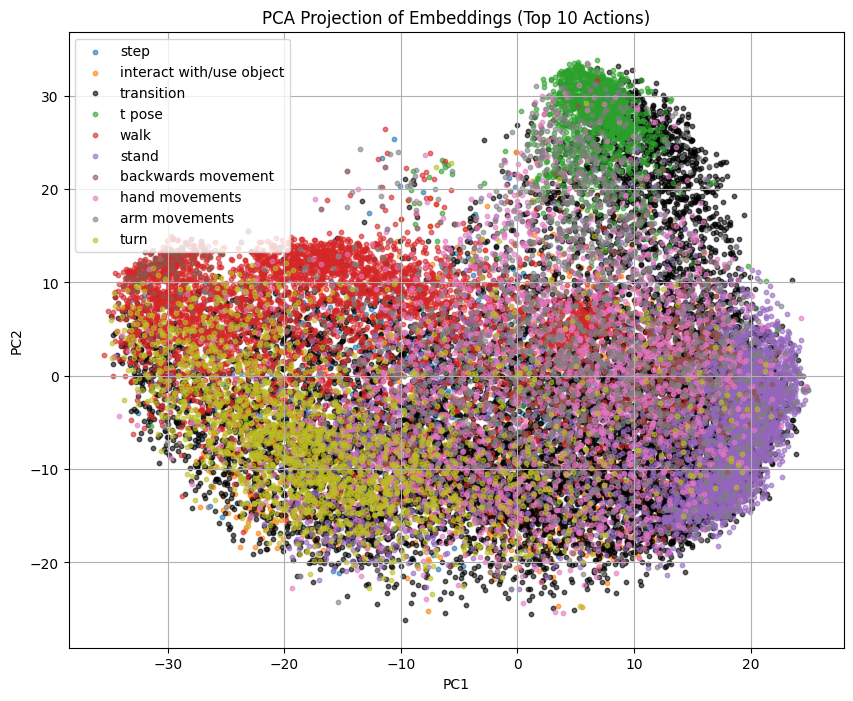

In [ ]:
from sklearn.decomposition import IncrementalPCA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ipca = IncrementalPCA(n_components=2)
batch_size = 1000
all_embeddings = []
all_labels = []

action_counts = {action: action_stats[action]['count'] for action in actions}
sorted_actions = sorted(action_counts, key=action_counts.get, reverse=True)

K = 10
top_actions = sorted_actions[:K]

for action in top_actions:
    folder = os.path.join("tmp", action)
    files = [f for f in os.listdir(folder) if f.endswith(".pt")]

    for i in range(0, len(files), batch_size):
        batch_files = files[i:i+batch_size]
        batch = []

        for file in batch_files:
            mu, logvar = torch.load(os.path.join(folder, file)).squeeze(0)
            embedding = mu.view(-1)
            batch.append(embedding.detach().cpu().numpy())

        batch = np.stack(batch)
        ipca.partial_fit(batch)

for action in top_actions:
    folder = os.path.join("tmp", action)
    files = [f for f in os.listdir(folder) if f.endswith(".pt")]

    for i in range(0, len(files), batch_size):
        batch_files = files[i:i+batch_size]
        batch = []

        for file in batch_files:
            mu, logvar = torch.load(os.path.join(folder, file)).squeeze(0)
            embedding = mu.view(-1)
            
            batch.append(embedding.detach().cpu().numpy())

        batch = np.stack(batch)
        reduced = ipca.transform(batch)

        all_embeddings.append(reduced)
        all_labels.extend([action] * len(batch))

all_embeddings = np.vstack(all_embeddings)

plt.figure(figsize=(10, 8))
for action in set(all_labels):
    mask = [label == action for label in all_labels]
    subset = all_embeddings[mask]
    color = 'black' if action == 'transition' else None  # Set color to black for 'transition'
    plt.scatter(subset[:, 0], subset[:, 1], label=action, alpha=0.6, s=10, c=color)

plt.legend()
plt.title("PCA Projection of Embeddings (Top {} Actions)".format(K))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()